## Import libraries

In [1]:
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import richdem as rd
from skimage.measure import label, regionprops, regionprops_table
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import pandas as pd
from matplotlib.colors import LightSource
import time
import sys
from alive_progress import alive_bar

%matplotlib inline

## Import data

In [2]:
# import raster
rast = rasterio.open(r'.\DEM\6801_2_10_z33_ClippedRegion.tif')
arr = rast.read(1)

## Produce  and operate lowpass filter to remove high frequency features from the layer

In [3]:
# Borrow filter from Classify_moraine.ipynb
# Filter is nPix x nPix, in this case 

def kernel_square(nPix):
    """
    Function to define a square kernel of equal value for performing averaging
    :param nPix: size of the kernel in pixel
    :return: kernel matrix
    """
    print("Averaging kernel of " + str(nPix) + " by " + str(nPix))
    kernel = np.empty([nPix, nPix])
    kernel.fill(1)
    kernel /= kernel.sum()   # kernel should sum to 1!  :)
    return kernel


def smooth(mat, kernel):
    """
    Function that produce a smoothed version of the 2D array
    :param mat: Array to smooth
    :param nPix: kernel array (output) from the function kernel_square()
    :return: smoothed array
    """
    r = cv2.filter2D(mat, -1, kernel)
    print("Smoothing done ...")
    return r

Averaging kernel of 20 by 20
Smoothing done ...


Text(0.5, 1.0, 'LowPass_Rogens')

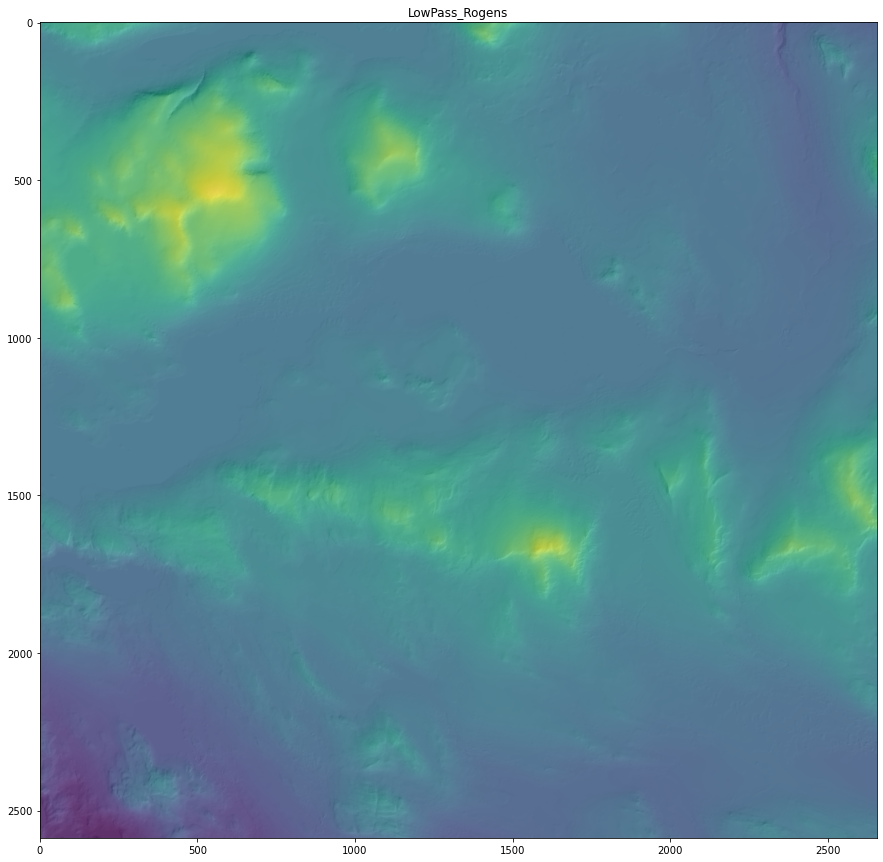

In [4]:
# Produce low pass filter of features lower than 200 m sq
low_200 = smooth(arr, kernel_square(20))
plt.figure(figsize=(15,15))
ls = LightSource(azdeg=135, altdeg=45)
shade = ls.hillshade(arr, vert_exag=0.5, dx=10, dy=10, fraction=1.0)
plt.imshow(shade, cmap=plt.cm.gray)
plt.imshow(low_200, alpha=0.7)
plt.title('LowPass_Rogens')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


Text(0.5, 1.0, 'High fq filtered slope')

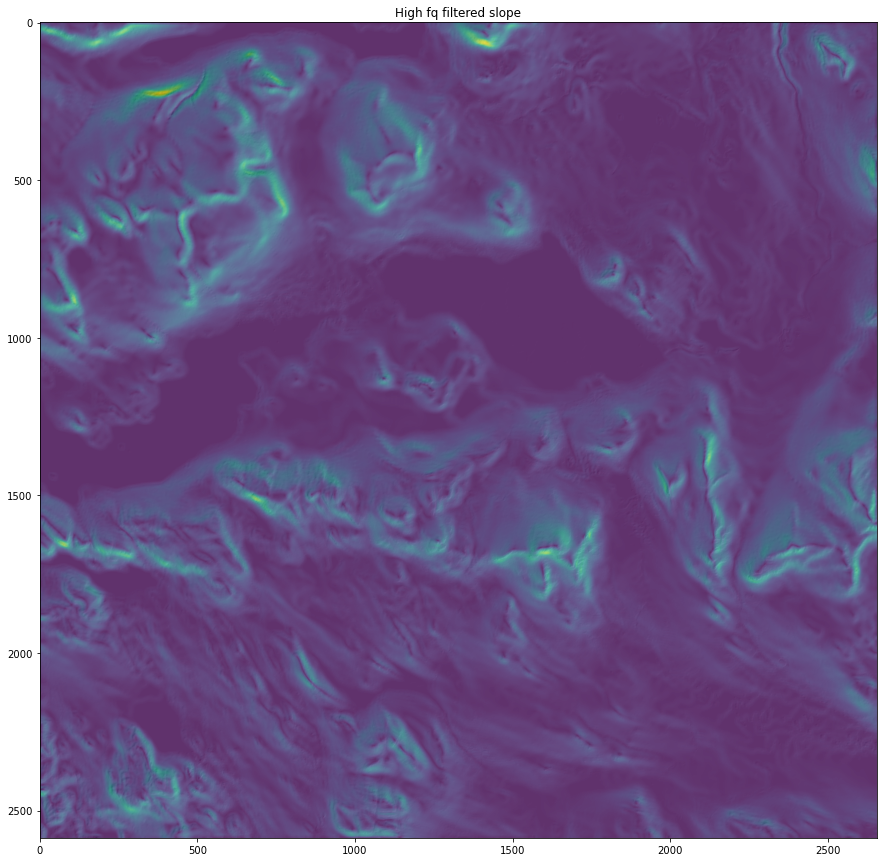

In [5]:
## Produce a general slope surface
# Convert above surface to richdem array
r200 = rd.rdarray(low_200, no_data=np.nan)

slope = rd.TerrainAttribute(r200, attrib='slope_riserun')
df = pd.DataFrame()

plt.figure(figsize=(15,15))
ls = LightSource(azdeg=135, altdeg=45)
shade = ls.hillshade(arr, vert_exag=0.5, dx=10, dy=10, fraction=1.0)
plt.imshow(shade, cmap=plt.cm.gray)
plt.imshow(slope, alpha=0.7)
plt.title('High fq filtered slope')

## Laplacian Filter

In [6]:
## Define variables
# Kernel = kernel_square
# Low pass array = low_200 or r200
# DEM = arr
bitdepth = cv2.CV_32F
window_DEM = "Laplacian_DEM"
window_Low_Pass = "Laplacian_Low_Pass"

In [7]:
# Apply Laplacian filtering function
# To DEM
Lap_DEM = cv2.Laplacian(arr, bitdepth, kernel_square(20))

# Display laplacian DEM filtered image
#cv2.imshow(window_DEM, Lap_DEM)
#cv2.waitKey(0)

Averaging kernel of 20 by 20


In [8]:
# To Low pass filter
Lap_LPF = cv2.Laplacian(r200, bitdepth, kernel_square(20))

# Display laplacian Low pass filter filtered image
#cv2.imshow(window_Low_Pass, Lap_LPF)
#cv2.waitKey(0)

Averaging kernel of 20 by 20


## Writing layers to GeoTIFF

In [9]:
## Write slope layer to raster

rast.transform

GeneralSlope = rasterio.open(r'.\DEM\Geomorphometrics\GenSlope_v1.tif', 'w', driver='GTiff',
                             height = arr.shape[0], width = arr.shape[1],
                             count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                             transform = rast.transform)
GeneralSlope.write(slope, 1)
GeneralSlope.close()

In [10]:
## Write Laplacian DEM to raster

LapDEM_Out = rasterio.open(r'.\DEM\Geomorphometrics\LapDEM_v1.tiff', 'w', driver='GTiff',
                             height = arr.shape[0], width = arr.shape[1],
                             count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                             transform = rast.transform)
LapDEM_Out.write(Lap_DEM, 1)
LapDEM_Out.close()

In [11]:
## Write Laplacian Low Pass filter to raster

LapLPF_Out = rasterio.open(r'.\DEM\Geomorphometrics\LapLPF_v1.tiff', 'w', driver='GTiff',
                             height = arr.shape[0], width = arr.shape[1],
                             count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                             transform = rast.transform)
LapLPF_Out.write(Lap_LPF, 1)
LapLPF_Out.close()